In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import welch
from scipy.interpolate import interp1d
from scipy.special import erf
from zipfile import ZipFile

from config import *
from functions import *
from sim import *
from read_ramses import *

aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list)


In [3]:
# choose simulation
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(aexp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.

Dump: 52
a_exp: 0.1
Maximum AMR level: 13


In [4]:
def load_death(num=1000000):
    
    if not os.path.isfile('stardeath/id.npy'):
        with ZipFile('stardeath.npz', 'r') as f:
            f.extractall(path='stardeath/', members=['num_dump.npy', 'id.npy', 'level.npy', 'mass.npy', 'coord.npy', 'density.npy', 'temperature.npy', 'metallicity.npy', 'energy_turb.npy', 'b_turb.npy', 'time.npy'])

    stardeath = SimpleNamespace(
        id=np.load('stardeath/id.npy', mmap_mode='r')[-num:],
        level=np.load('stardeath/level.npy', mmap_mode='r')[-num:],
        mass=np.load('stardeath/mass.npy', mmap_mode='r')[-num:],
        density=np.load('stardeath/density.npy', mmap_mode='r')[-num:],
        temperature=np.load('stardeath/temperature.npy', mmap_mode='r')[-num:],
        metallicity=np.load('stardeath/metallicity.npy', mmap_mode='r')[-num:],
        energy_turb=np.load('stardeath/energy_turb.npy', mmap_mode='r')[-num:],
        b_turb=np.load('stardeath/b_turb.npy', mmap_mode='r')[-num:],
        time=np.load('stardeath/time.npy', mmap_mode='r')[-num:]
    )
    
    return stardeath
    

In [5]:
starbirth = SimpleNamespace(**np.load("starbirth.npz"))
#stardeath = load_death()


In [39]:
vmin = 1e-23
vmax = 1e-10
nbin = 64

boxlen = 100*const.Mpc/const.h0
aexp = proper_time_to_aexp_interp(starbirth.time)
dx = aexp * boxlen / 2**starbirth.level
c_s = np.sqrt(2/3 * const.k_B * starbirth.temperature / const.m_p) # sound speed
mach_turb = np.sqrt(2/3 * starbirth.energy_turb) / c_s # turbulent Mach number
alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * starbirth.density * dx**2) # virial parameter

density1d, hist1 = calc_hist1d(starbirth.density, vmin, vmax, weight=starbirth.mass, nbin=nbin, do_log=True)
#denisty1d, hist2 = calc_hist_density_mff(vmin, vmax, nbin, starbirth.density, mach_turb, alpha_vir, weight=starbirth.mass, do_trunc=False)
#denisty1d, hist3 = calc_hist_density_mff(vmin, vmax, nbin, starbirth.density, mach_turb, alpha_vir, weight=starbirth.mass, do_trunc=True)


Text(0.5, 1.0, 'fiducial model')

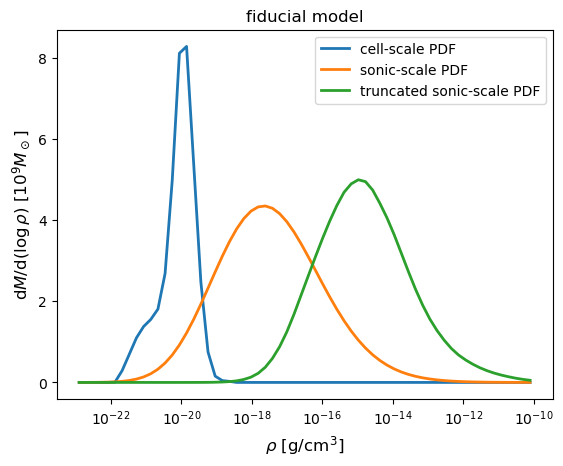

In [40]:
unit = 1e9*const.M_sol
plt.plot(density1d, hist1/unit, lw=2, label='cell-scale PDF')
plt.plot(density1d, hist2/unit, lw=2, label='sonic-scale PDF')
plt.plot(density1d, hist3/unit, lw=2, label='truncated sonic-scale PDF')
#plt.axvline(x=2.6e-13, color='black', linestyle='--', label='1st core density')
    
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^{3}}$]', fontsize=12)
plt.ylabel(r'${\rm d}M/{\rm d}(\log \rho)$ [$10^9 M_\odot$]', fontsize=12)
#plt.xlim(1e1)
#plt.ylim(1e5)

plt.legend()
plt.title('fiducial model')

#save_fig('rhopdfcomplog')


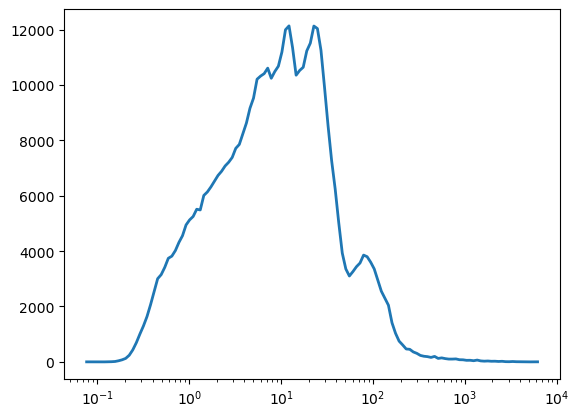

In [165]:
n_H = const.X_cosmo * stardeath.density / const.m_H
r_cool = 3 * const.pc * (stardeath.metallicity / const.Z_sol)**(-0.082) * (n_H / 100)**(-0.42)
box_size = 100 * const.Mpc
aexp = proper_time_to_aexp_interp(stardeath.time)
dx = aexp * box_size / 2**np.max(stardeath.level)
gamma = 5/3
c_s = np.sqrt(gamma * const.k_B * stardeath.temperature / const.m_p)
mach_turb = np.sqrt(2/3 * stardeath.energy_turb) / c_s
ls = dx / mach_turb**2

ratio, hist = calc_hist((r_cool / ls)[ls < dx], do_log=True, nbin=128)
pdf = hist / np.sum(hist) / (np.log10(ratio)[1] - np.log10(ratio)[0])
plt.plot(ratio, hist, lw=2)
plt.xscale('log')


0.712419


Text(0.5, 1.0, 'fiducial model')

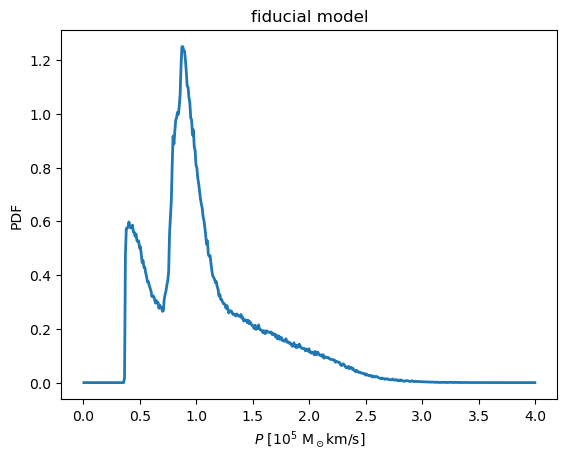

In [10]:
def fbk_ramses(n_H, metallicity, dx):

    r_cool = 3 * const.pc * (metallicity / const.Z_sol)**(-0.082) * (n_H / 100)**(-0.42)
    mom_SN = 1.42e5 * const.km * const.M_sol * (metallicity / const.Z_sol)**(-0.137) * (n_H / 100)**(-0.16)
    mom = mom_SN * np.minimum(1, (dx / r_cool)**(3/2)) * (r_cool < 4 * dx)
    return mom

n_H = const.X_cosmo * stardeath.density / const.m_H
box_size = 100 * const.Mpc
aexp = proper_time_to_aexp_interp(stardeath.time)
dx = aexp * box_size / 2**np.max(stardeath.level)
mom = fbk_ramses(n_H, stardeath.metallicity, dx)

print(np.sum(mom > 0) / mom.size)

mom1d, pdf = calc_hist(mom / (1e5 * const.M_sol * const.km), 0.001, 4, weight=None, nbin=512, do_log=False, do_norm=True)
plt.plot(mom1d, pdf, lw=2)

plt.xlabel(r'$P$ [${\rm 10^5~M_\odot km/s}$]')
plt.ylabel(r'PDF')
plt.title(sim_latex)


Text(0.5, 1.0, '$b_{\\rm turb} = 1.0$')

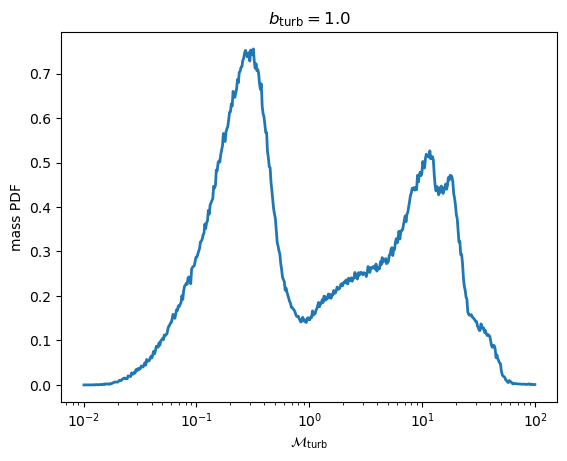

In [60]:
gamma = 5/3
c_s = np.sqrt(gamma * const.k_B * stardeath.temperature / const.m_p) # sound speed
mach_turb = np.sqrt(2/3 * stardeath.energy_turb) / c_s

mach_turb1d, pdf = calc_hist(mach_turb, 1e-2, 1e2, weight=None, nbins=512, do_log=True, do_norm=True)
plt.plot(mach_turb1d, pdf, lw=2)

plt.xscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm turb}$')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)

# save_fig('machturbSNe_bturbp0')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
0.846272
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
0.543054
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
0.297331


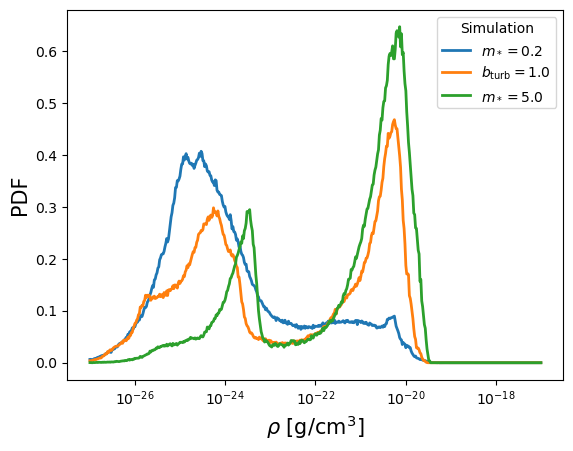

In [134]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()

    density1d, pdf = calc_hist(stardeath.density, 1e-27, 1e-17, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(density1d, pdf, lw=2, label=sim_latex)
    
    print(np.sum(stardeath.density < 1e-22) / stardeath.density.size)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

# save_fig('rho-comp')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Saved figure as 'metaldeath-comp-013020241632.png'


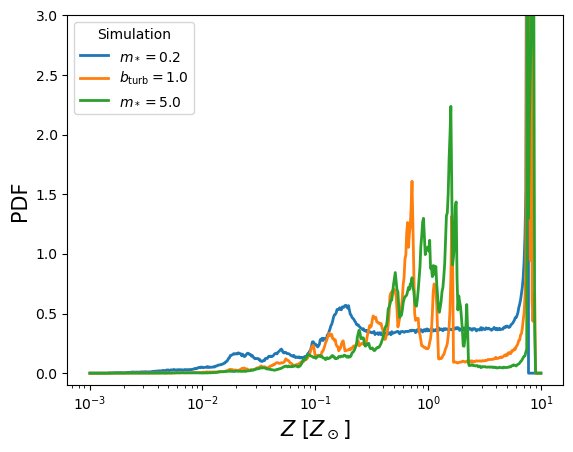

In [133]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()

    metallicity, pdf = calc_hist(stardeath.metallicity / const.Z_sol, 1e-3, 1e1, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(metallicity, pdf, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

plt.ylim(-0.1, 3)

save_fig('metaldeath-comp')


In [75]:
sorter = np.argsort(starbirth.id)
idx_birth = sorter[np.searchsorted(starbirth.id, stardeath.id, sorter=sorter)]

density_ratio_db = stardeath.density / starbirth.density[idx_birth]


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Saved figure as 'rhoratio-comp-013020241534.png'


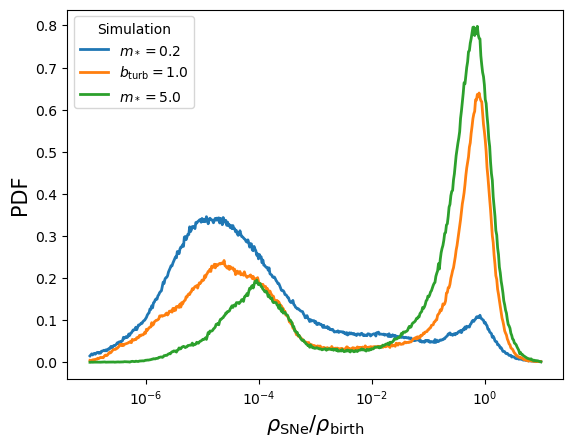

In [91]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()
    
    sorter = np.argsort(starbirth.id)
    idx_birth = sorter[np.searchsorted(starbirth.id, stardeath.id, sorter=sorter)]
    density_ratio_db = stardeath.density / starbirth.density[idx_birth]

    density_ratio_db1d, pdf = calc_hist(density_ratio_db, 1e-7, 1e1, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(density_ratio_db1d, pdf, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho_{\rm SNe} / \rho_{\rm birth}$', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

save_fig('rhoratio-comp')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Saved figure as 'tempratio-comp-013020241537.png'


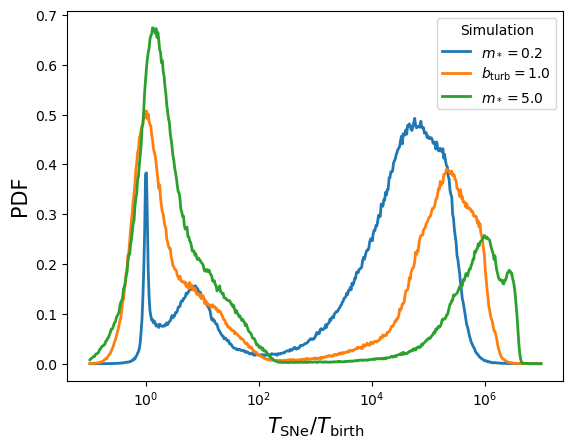

In [94]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()
    
    sorter = np.argsort(starbirth.id)
    idx_birth = sorter[np.searchsorted(starbirth.id, stardeath.id, sorter=sorter)]
    temperature_ratio_db = stardeath.temperature / starbirth.temperature[idx_birth]

    temperature_ratio_db1d, pdf = calc_hist(temperature_ratio_db, 1e-1, 1e7, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(temperature_ratio_db1d, pdf, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$T_{\rm SNe} / T_{\rm birth}$', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

#save_fig('tempratio-comp')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Saved figure as 'metalratio-comp-013020241541.png'


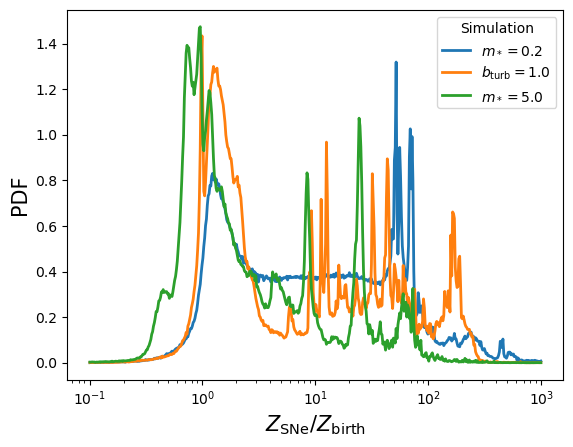

In [97]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()
    
    sorter = np.argsort(starbirth.id)
    idx_birth = sorter[np.searchsorted(starbirth.id, stardeath.id, sorter=sorter)]
    metallicity_ratio_db = stardeath.metallicity / starbirth.metallicity[idx_birth]

    metallicity_ratio_db, pdf = calc_hist(metallicity_ratio_db, 1e-1, 1e3, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(metallicity_ratio_db, pdf, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z_{\rm SNe} / Z_{\rm birth}$', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

save_fig('metalratio-comp')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Saved figure as 'machturbratio-comp-013020241544.png'


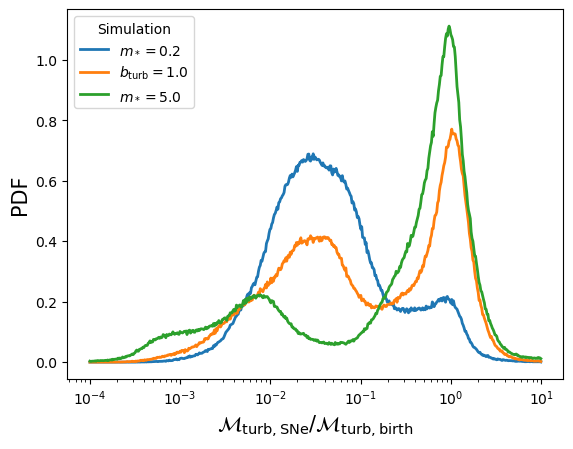

In [101]:
sim_list = [(9, "mstar0p2"), (9, "bturb1p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth.npz"))
    stardeath = load_death()
    
    sorter = np.argsort(starbirth.id)
    idx_birth = sorter[np.searchsorted(starbirth.id, stardeath.id, sorter=sorter)]
    
    gamma = 5/3
    c_s_birth = np.sqrt(gamma * const.k_B * starbirth.temperature / const.m_p) # sound speed
    mach_turb_birth = np.sqrt(2/3 * starbirth.energy_turb) / c_s_birth
    c_s_death = np.sqrt(gamma * const.k_B * stardeath.temperature / const.m_p) # sound speed
    mach_turb_death = np.sqrt(2/3 * stardeath.energy_turb) / c_s_death
    mach_turb_ratio_db = mach_turb_death / mach_turb_birth[idx_birth]

    mach_turb_ratio_db, pdf = calc_hist(mach_turb_ratio_db, 1e-4, 1e1, weight=None, nbins=512, do_log=True, do_norm=True)
    plt.plot(mach_turb_ratio_db, pdf, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm turb, SNe} / \mathcal{M}_{\rm turb, birth}$', fontsize=15)
plt.ylabel(r'PDF', fontsize=15)
plt.legend(title='Simulation')

save_fig('machturbratio-comp')


Saved figure as 'phase-SNe-mstar1p0-013020241554.png'


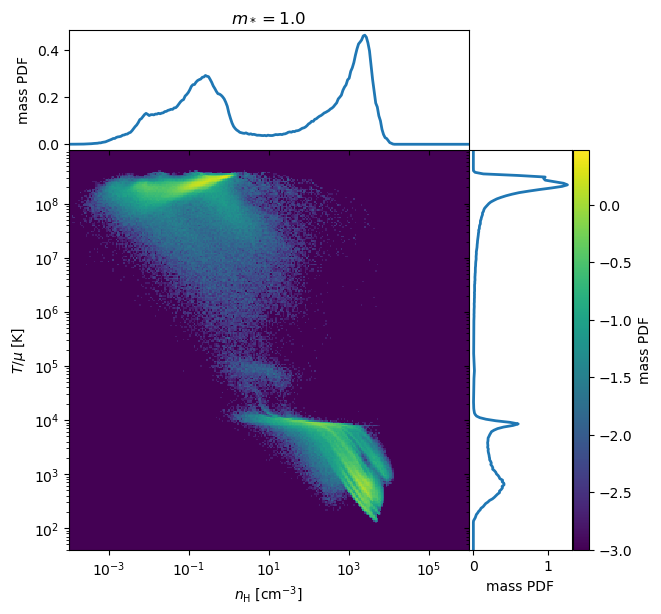

In [121]:
n_H = const.X_cosmo * stardeath.density / const.m_H
temp = stardeath.temperature

axs, n_H2d, mach_turb2d, pdf, im = plot_pdf2d(n_H, temp, 1e-4, 1e6, 4e1, 1e9, 1e-3, 3e0, weight=None, nbins=256)

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='mass PDF')

axs[0].set_xlabel(r'$n_{\rm H}$ [${\rm cm^{-3}}$]')
axs[0].set_ylabel(r'$T / \mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
#axs[1].set_title(sim_latex)
axs[1].set_title(r'$m_* = 1.0$')

save_fig('phase-SNe-mstar1p0')


In [188]:
aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list)

box_size = 100 * const.Mpc
aexp = proper_time_to_aexp_interp(starbirth.time)
dx = aexp * box_size / 2**starbirth.level

gamma = 5/3
c_s = np.sqrt(gamma * const.k_B * starbirth.temperature / const.m_p) # sound speed
mach_turb = np.sqrt(2/3 * starbirth.energy_turb) / c_s # turbulent Mach number
alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * starbirth.density * dx**2) # virial parameter


Text(0.5, 1.0, '$b_{\\rm turb} = 1.0$ (highres)')

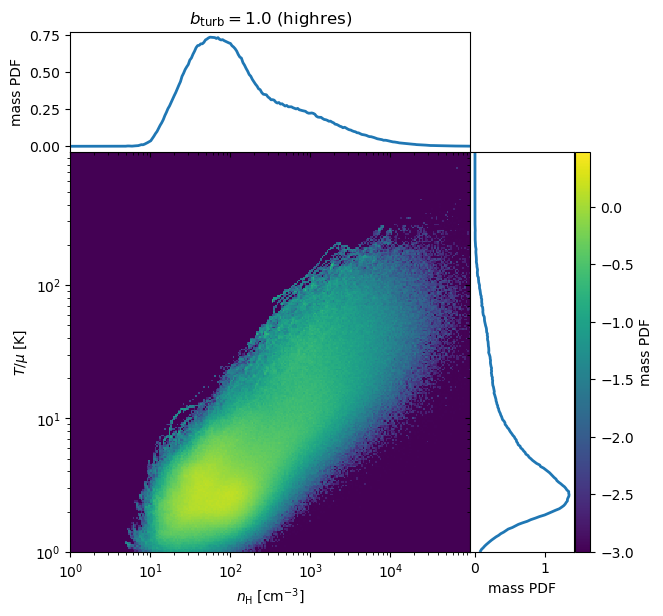

In [7]:
axs, alpha_vir2d, mach_turb2d, pdf, im = plot_pdf2d(alpha_vir, mach_turb, 1e0, 1e5, 1e0, 1e3, 1e-3, 3e0, weight=starbirth.mass, nbins=256)
add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='mass PDF')

axs[0].set_xlabel(r'$n_{\rm H}$ [${\rm cm^{-3}}$]')
axs[0].set_ylabel(r'$T / \mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim_latex)
#axs[1].set_title(r'$m_* = 1.0$')

# save_fig('phase-mstar1p0')

In [125]:
aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list)

box_size = 100 * const.Mpc
aexp = proper_time_to_aexp_interp(starbirth.time)
dx = aexp * box_size / 2**starbirth.level
eps_sf = calc_eps_sf2(starbirth.density, starbirth.energy_turb, starbirth.temperature, dx, b_turb=1.0)

dt = 500 * const.yr
t_ff = np.sqrt(3 * np.pi / (32 * const.G * starbirth.density))
m_gas = eps_sf * starbirth.density * dx**3


Text(0.5, 1.0, '$b_{\\rm turb} = 1.0$ (highres)')

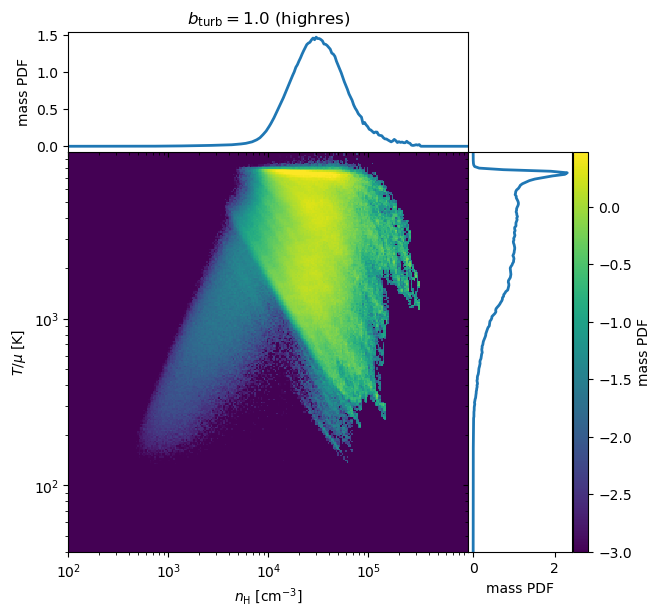

In [132]:
n_H = const.X_cosmo * starbirth.density / const.m_H
temp = starbirth.temperature
cond = m_gas > 1 * const.M_sol

axs, n_H2d, mach_turb2d, pdf, im = plot_pdf2d(n_H[cond], temp[cond], 1e2, 1e6, 4e1, 1e4, 1e-3, 3e0, weight=starbirth.density[cond], nbins=256)

add_cbar_to_ax(im, ax=axs[2], size='15%', pad=0.01, label='mass PDF')

axs[0].set_xlabel(r'$n_{\rm H}$ [${\rm cm^{-3}}$]')
axs[0].set_ylabel(r'$T / \mu$ [${\rm K}$]')
axs[1].set_ylabel('mass PDF')
axs[2].set_xlabel('mass PDF')
axs[1].set_title(sim_latex)
#axs[1].set_title(r'$m_* = 1.0$')

#save_fig('phase-highres-womcut')


Text(0.5, 1.0, '$m_* = 0.2$, $\\varepsilon_{\\rm SF} > 0.1$')

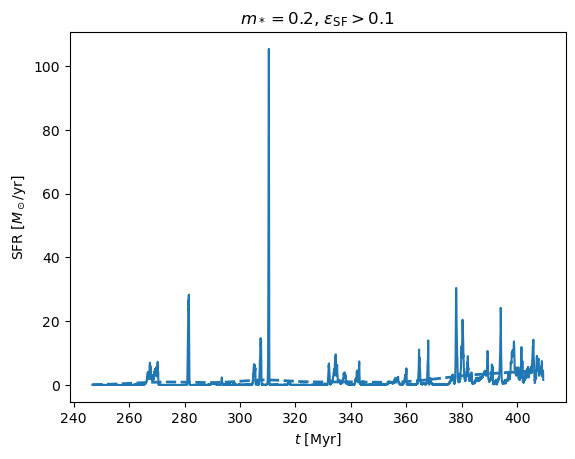

In [43]:
fsigma = 10 * const.Myr

time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=4096, do_log=False)
dt = np.diff(time)[0]
SFR = mass / dt
SFR_sm = gaussian_filter(SFR, sigma=(fsigma / dt))

plt.plot(time / const.Myr, SFR / (const.M_sol / const.yr), color='C0', linestyle='-')
plt.plot(time / const.Myr, SFR_sm / (const.M_sol / const.yr), color='C0', linestyle='--', lw=2)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")
plt.title(sim_latex)


/tmp/ipykernel_3672579/3886334214.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)


Text(0.5, 1.0, 'Variable $b_{\\rm turb}$')

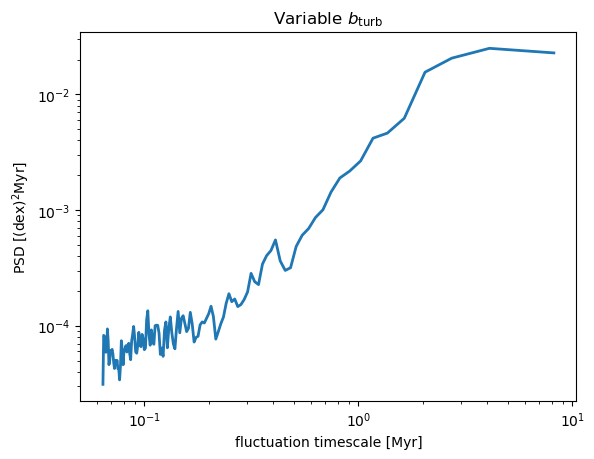

In [9]:
time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=4096, do_log=False, vmin=400*const.Myr)
dt = np.diff(time)[0]
SFR = mass / dt
log_SFR = np.log10(SFR)
freq, psd = welch(log_SFR, 1/dt, detrend='linear')

plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)

# save_fig("SFR-dxmin")


### PDF

In [120]:
np.sqrt(1.8800000e-29 * 8*np.pi*const.G/3) / (const.km/const.Mpc)


100.04177047174244

In [124]:
1 / 0.703000030517578**2


2.0234352534636475

In [117]:
H0

rho_crit = 3/(8*np.pi) * 

1.8800000e-29, 3/(8*np.pi)*0.7**2*(const.km/const.Mpc)**2/const.G


SyntaxError: invalid syntax (4233702893.py, line 1)

Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2cut0p1'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2cut0p01'.
Saved figure as 'eps_sf_discrepancy_before-021520241522.png'


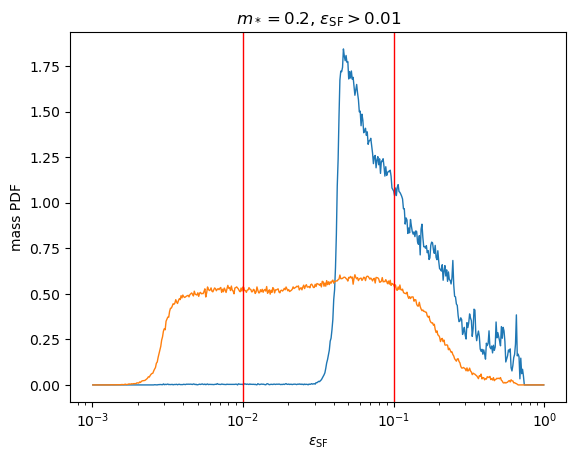

In [116]:
aexp_list = np.linspace(8e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list)

box_size = 100 * const.Mpc
b_turb = 1.0

sim_list = [(9, "mstar0p2cut0p1"), (9, "mstar0p2cut0p01")]

for sim_round, sim_name in sim_list:
    
    move_to_sim_dir(sim_round, sim_name)
    sim_latex = sim_name_to_latex[sim_name]
    starbirth = SimpleNamespace(**np.load("starbirth2.npz"))

    temp = starbirth.temperature
    aexp = proper_time_to_aexp_interp(starbirth.time)
    dx = aexp * box_size / 2**starbirth.level
    c_s = np.sqrt(const.k_B * temp / const.m_p) # sound speed
    mach_turb = np.sqrt(2/3 * starbirth.energy_turb) / c_s # turbulent Mach number
    alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * starbirth.density * dx**2) # virial parameter
    s_crit = np.log(alpha_vir * (1 + 2 * mach_turb**4 / (1 + mach_turb**2))) # lognormal critical density for star formation
    sigma_s = np.sqrt(np.log(1 + b_turb**2 * mach_turb**2)) # standard deviation of the lognormal subgrid density distribution
    eps_sf = 1/2 * np.exp(3/8 * sigma_s**2) * (1 + erf((sigma_s**2 - s_crit) / np.sqrt(2 * sigma_s**2))) # star formation efficiency

    cond = starbirth.time < aexp_to_proper_time(0.1)
    eps_sf1d, pdf = calc_hist(eps_sf[cond], 1e-3, 1e0, weight=starbirth.mass[cond], nbins=512, do_log=True, do_norm=True)
    plt.plot(eps_sf1d, pdf, lw=1)

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)

plt.axvline(x=0.01, lw=1, color='red')
plt.axvline(x=0.1, lw=1, color='red')

save_fig('eps_sf_discrepancy_before')


In [191]:
box_size = 100 * const.Mpc
aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list)

def erf_wrapper(s, sigma_s):
    return erf((sigma_s**2 - s) / (np.sqrt(2) * sigma_s))

def calc_hist_density_mff(starbirth, vmin, vmax, nbins, bturb=1.0, gamma=5/3, cond=None):
    
    if np.all(cond) == None: cond = np.ones_like(starbirth.density)
    
    bin_width = (np.log10(vmax) - np.log10(vmin)) / nbins
    bin_edge = 10**np.linspace(np.log10(vmin), np.log10(vmax), nbins+1)
    bin_center = 10**(np.log10(bin_edge) + bin_width/2)[:-1]
    pdf = np.zeros(nbins)
    
    aexp = proper_time_to_aexp_interp(starbirth.time[cond])
    dx = aexp * box_size / 2**starbirth.level[cond]
    c_s = np.sqrt(gamma * const.k_B * starbirth.temperature[cond] / const.m_p) # sound speed
    mach_turb = np.sqrt(2/3 * starbirth.energy_turb[cond]) / c_s # turbulent Mach number
    alpha_vir = 15 / np.pi * c_s**2 * (1 + mach_turb**2) / (const.G * starbirth.density[cond] * dx**2) # virial parameter
    s_crit = np.log(alpha_vir * (1 + 2 * mach_turb**4 / (1 + mach_turb**2))) # lognormal critical density for star formation
    sigma_s = np.sqrt(np.log(1 + bturb**2 * mach_turb**2)) # standard deviation of the lognormal subgrid density distribution
    
    for i in range(nbins):
        s_bin_min = np.maximum(np.log(bin_edge[i]) - np.log(starbirth.density[cond]), s_crit)
        s_bin_max = np.maximum(np.log(bin_edge[i+1]) - np.log(starbirth.density[cond]), s_crit)
        pdf_per_part = (erf_wrapper(s_bin_min, sigma_s) - erf_wrapper(s_bin_max, sigma_s)) / (1 + erf_wrapper(s_crit, sigma_s))
        pdf_per_part = np.nan_to_num(pdf_per_part)
        pdf[i] = np.sum(starbirth.mass[cond] * pdf_per_part)
    pdf /= (np.sum(starbirth.mass[cond]) * bin_width)
    return bin_center, pdf

bin_center, pdf = calc_hist_density_mff(starbirth, 1e-20, 1e-10, 128, bturb=starbirth.b_turb, cond=(starbirth.time < 600*const.Myr))


/tmp/ipykernel_348556/4019813530.py:29: RuntimeWarning: invalid value encountered in divide
  pdf_per_part = (erf_wrapper(s_bin_min, sigma_s) - erf_wrapper(s_bin_max, sigma_s)) / (1 + erf_wrapper(s_crit, sigma_s))


Text(0, 0.5, 'mass PDF')

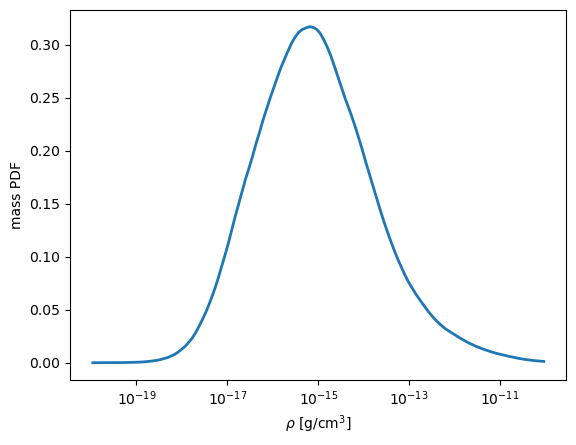

In [192]:
plt.plot(bin_center, pdf, lw=2)
plt.xscale('log')

plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')


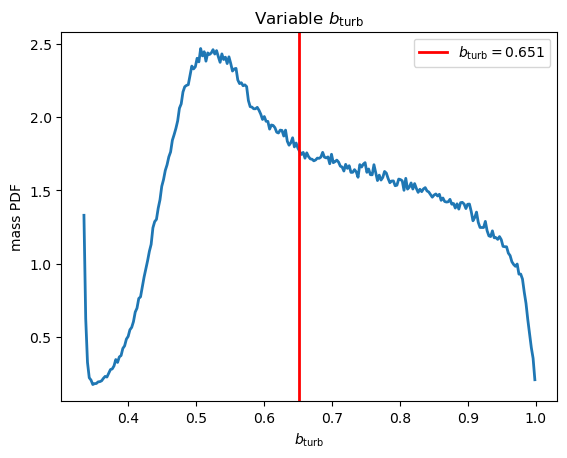

In [284]:
b_turb1d, pdf = calc_hist(starbirth.b_turb, 1/3, 1.0, weight=starbirth.mass, nbins=256, do_log=False, do_norm=True)
plt.plot(b_turb1d, pdf, lw=2)

plt.xlabel(r'$b_{\rm turb}$')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)

b_turb_median = median_weighted(starbirth.b_turb, starbirth.mass)
plt.axvline(x=b_turb_median, lw=2, color='red')
add_custleg_to_ax([r'$b_{\rm turb} = %.3g$' % b_turb_median], ['red'])

# save_fig('bturbpdf_highres')


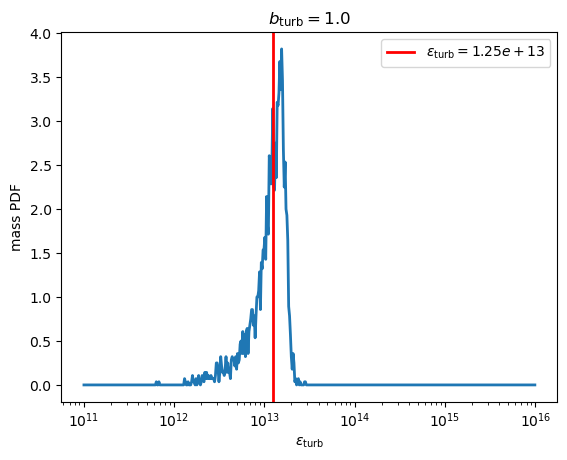

In [165]:
energy_turb1d, pdf = calc_hist(starbirth.energy_turb, 1e11, 1e16, weight=starbirth.mass, nbins=512, do_log=True, do_norm=True)
plt.plot(energy_turb1d, pdf, lw=2)

plt.xlabel(r'$\varepsilon_{\rm turb}$')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)
plt.xscale('log')

energy_turb_median = median_weighted(starbirth.energy_turb, starbirth.mass)
plt.axvline(x=energy_turb_median, lw=2, color='red')
add_custleg_to_ax([r'$\varepsilon_{\rm turb} = %.3g$' % energy_turb_median], ['red'])

# save_fig('bturbpdf_highres')


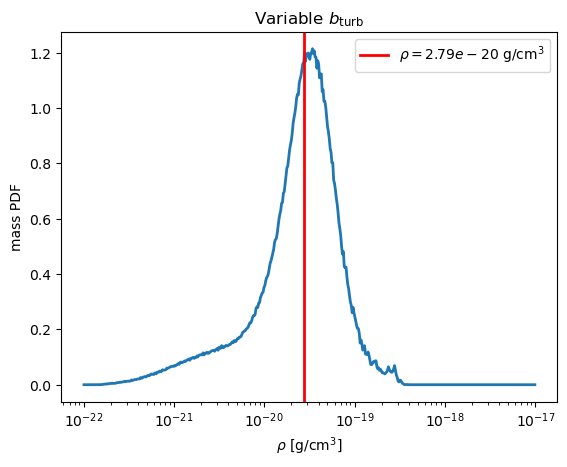

In [67]:
density1d, pdf = calc_hist(starbirth.density, 1e-22, 1e-17, weight=starbirth.mass, nbins=512, do_log=True, do_norm=True)
plt.plot(density1d, pdf, lw=2)

plt.xlabel(r'$\rho$ [${\rm g/cm^{3}}$]')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)
plt.xscale('log')

density_median = median_weighted(starbirth.density, starbirth.mass)
plt.axvline(x=density_median, lw=2, color='red')
add_custleg_to_ax([r'$\rho = %.3g~{\rm g/cm^3}$' % density_median], ['red'])

# save_fig('bturbpdf_highres')


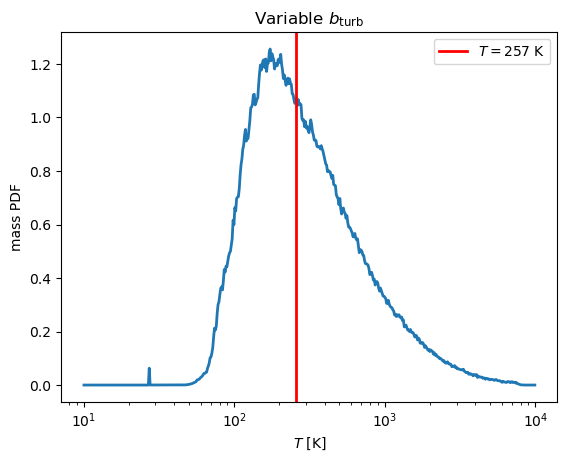

In [68]:
temp1d, pdf = calc_hist(starbirth.temperature, 1e1, 1e4, weight=starbirth.mass, nbins=512, do_log=True, do_norm=True)
plt.plot(temp1d, pdf, lw=2)

plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)
plt.xscale('log')

temp_median = median_weighted(starbirth.temperature, starbirth.mass)
plt.axvline(x=temp_median, lw=2, color='red')
add_custleg_to_ax([r'$T = %.3g~{\rm K}$' % temp_median], ['red'])

# save_fig('bturbpdf_highres')


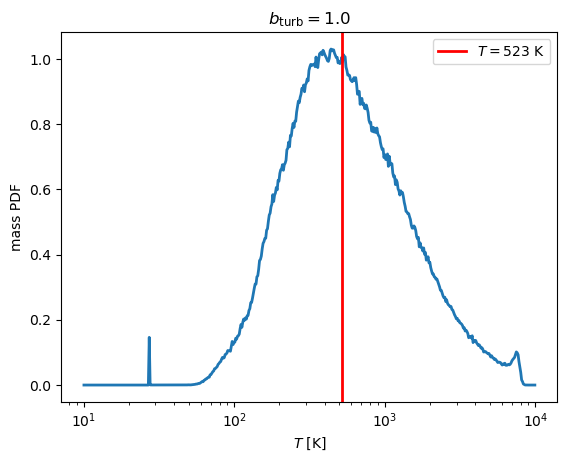

In [320]:
temp1d, pdf = calc_hist(starbirth.temperature, 1e1, 1e4, weight=starbirth.mass, nbins=512, do_log=True, do_norm=True)
plt.plot(temp1d, pdf, lw=2)

plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel(r'mass PDF')
plt.title(sim_latex)
plt.xscale('log')

temp_median = median_weighted(starbirth.temperature, starbirth.mass)
plt.axvline(x=temp_median, lw=2, color='red')
add_custleg_to_ax([r'$T = %.3g~{\rm K}$' % temp_median], ['red'])

# save_fig('bturbpdf_highres')


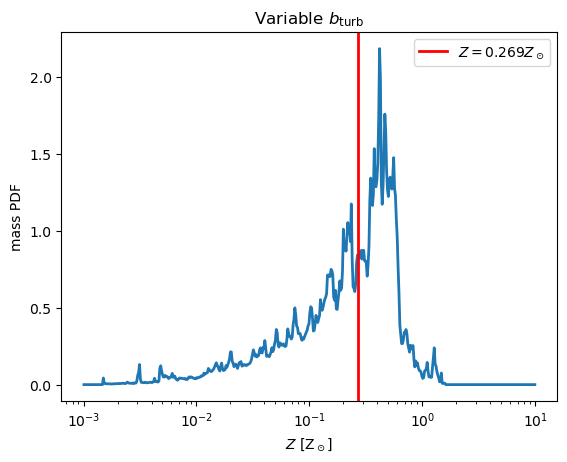

In [286]:
metallicity1d, pdf = calc_hist(starbirth.metallicity, 1e-3*const.Z_sol, 1e1*const.Z_sol, weight=starbirth.mass, nbins=512, do_log=True, do_norm=True)
plt.plot(metallicity1d / const.Z_sol, pdf, lw=2)

plt.xlabel(r'$Z$ [${\rm Z_\odot}$]')
plt.ylabel(r'mass PDF')
plt.xscale('log')
plt.title(sim_latex)

metallicity_median = median_weighted(starbirth.metallicity, starbirth.mass)
plt.axvline(x=metallicity_median / const.Z_sol, lw=2, color='red')
add_custleg_to_ax([r'$Z = %.3g Z_\odot$' % (metallicity_median / const.Z_sol)], ['red'])

# save_fig('bturbpdf_highres')


### simulation comparison


Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.


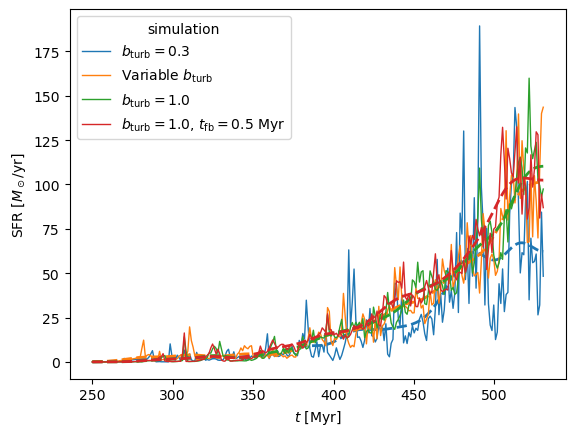

In [229]:
list_of_sim_round = [9]
list_of_sim_name = ["bturb0p3", "bturbfunc", "bturb1p0", "fastfeedback"]
nbins = 300
filter_sigma = 10 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]
        starbirth = SimpleNamespace(**np.load("starbirth.npz"))

        fsigma = 10 * const.Myr
        time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=256, do_log=False)
        dt = np.diff(time)[0]
        SFR = mass / dt
        SFR_sm = gaussian_filter(SFR, sigma=(fsigma / dt))

        plt.plot(time1d / const.Myr, SFR / (const.M_sol / const.yr), color='C%d' % i, linestyle='-', label=sim_latex, lw=1)
        plt.plot(time1d / const.Myr, SFR_sm / (const.M_sol / const.yr), color='C%d' % i, linestyle='--', lw=2)
        
plt.ylabel(r"SFR [$M_\odot / {\rm yr}$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='simulation')
    
# save_fig("SFR-comp-r10")


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.


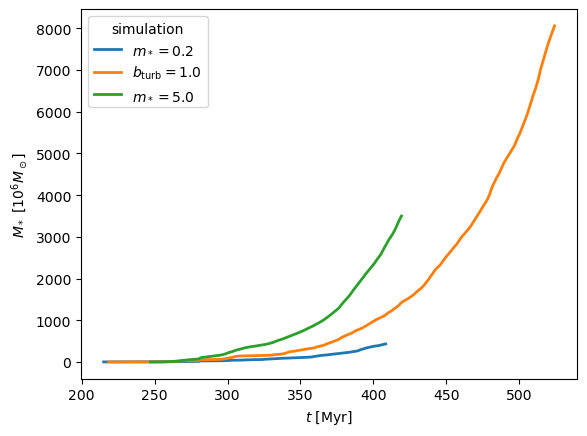

In [42]:
list_of_sim_round = [9]
# list_of_sim_name = ["bturb0p3", "bturbfunc", "bturb1p0", "fastfeedback"]
list_of_sim_name = ["mstar0p2", "bturb1p0", "mstar5p0"]
nbins = 300
filter_sigma = 10 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]
        starbirth = SimpleNamespace(**np.load("starbirth.npz"))

        time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=256, do_log=False)
        cummass = np.cumsum(mass)
        
        plt.plot(time / const.Myr, cummass / const.M_sol / 1e6, lw=2, alpha=1., label=sim_latex)
        
plt.ylabel(r"$M_*$ [$10^6 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='simulation')
    
# save_fig("starmass-comp-mstar")


Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round10/bturb1p0_highres'.


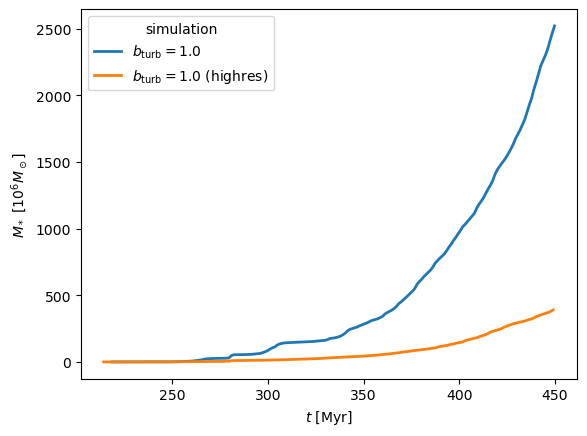

In [9]:
list_of_sim_round = [9, 10]
# list_of_sim_name = ["bturb0p3", "bturbfunc", "bturb1p0", "fastfeedback"]
list_of_sim_name = ["bturb1p0", "bturb1p0_highres"]
nbins = 300
filter_sigma = 10 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = [sim_name for sim_name in sorted(os.listdir(round_dir))]
    else:
        list_of_sim_name_round = [sim_name for sim_name in list_of_sim_name if sim_name in sorted(os.listdir(round_dir))]

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]
        starbirth = SimpleNamespace(**np.load("starbirth.npz"))

        time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=256, do_log=False)
        cummass = np.cumsum(mass)
        cond = time < 450 * const.Myr
        
        plt.plot(time[cond] / const.Myr, cummass[cond] / const.M_sol / 1e6, lw=2, alpha=1., label=sim_latex)
        
plt.ylabel(r"$M_*$ [$10^6 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='simulation')
    
# save_fig("starmass-comp-mstar")


Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.


/tmp/ipykernel_449775/3097965819.py:27: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb1p0'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.


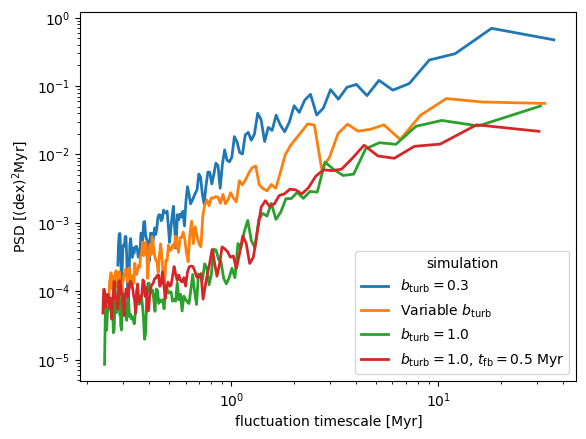

In [10]:
list_of_sim_round = [9]
list_of_sim_name = ["bturb0p3", "bturbfunc", "bturb1p0", "fastfeedback"]

nbins = 1024
tmin = 400 * const.Myr

for sim_round in list_of_sim_round:
    
    round_dir = os.path.join(sim_base_dir, "round%d" % sim_round)
    if list_of_sim_name == None: 
        list_of_sim_name_round = sorted(os.listdir(round_dir))
    else:
        list_of_sim_name_round = list_of_sim_name

    for i, sim_name in enumerate(list_of_sim_name_round):

        sim_dir = move_to_sim_dir(sim_round, sim_name)
        sim_latex = sim_name_to_latex[sim_name]
        starbirth = SimpleNamespace(**np.load("starbirth.npz"))
        
        time, mass = calc_hist(starbirth.time, weight=starbirth.mass, nbins=nbins, do_log=False, vmin=tmin)
        dt = np.diff(time)[0]
        SFR = mass / dt
        log_SFR = np.log10(SFR)
        freq, psd = welch(log_SFR, 1/dt, detrend='linear')

        plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)
        
plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='simulation')

#save_fig('PSD')
